# Set-up

In [393]:
import os
import torch
import numpy as np

from dataload import DataloaderWrapper

import seqpro as sp
import seqdata as sd
from eugene import preprocess as pp

import matplotlib.pyplot as plt

In [118]:
# Paths
data_dir = "/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/training/2023_12_27/HepG2/U2AF2/"
log_dir = "/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/models/2023_12_28/BPNet/U2AF2/"

# Data

In [119]:
# Data
train_sdata = sd.open_zarr(os.path.join(data_dir, 'train.zarr')).load()
valid_sdata = sd.open_zarr(os.path.join(data_dir, 'valid.zarr')).load()

# Instantiate model

In [120]:
import torch
import numpy as np
from bpnetlite import BPNet

In [121]:
# Create the model, we need 2 channels for the control tracks, 2 channels for the signal tracks, and to trim to 1000 bp of input
model = BPNet(n_outputs=1, n_control_tracks=1, trimming=(300-290)//2, name=os.path.join(log_dir, "bpnet"))
model

BPNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(65, 1, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)
)

# Training data

In [122]:
# Training transforms
def seq_trans(x):
    x = np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return x

def ctl_dtype(x):
    return np.expand_dims(x, axis=1).astype('f4')

def cov_dtype(x):
    return np.expand_dims(x, axis=1).astype('f4')[..., 5:-5]

def jitter(x):
    return sp.jitter(*x, max_jitter=32, length_axis=-1, jitter_axes=0)

def to_tensor(x):
    return tuple(torch.tensor(arr, dtype=torch.float32) for arr in x)

# Get the train dataloader
train_dl = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=['_sequence'],
    variables=['seq', 'control', 'signal'],
    num_workers=0,
    prefetch_factor=None,
    batch_size=128,
    transforms={
        ('seq', 'control', 'signal'): jitter,
        'seq': seq_trans,
        'control': ctl_dtype,
        'signal': cov_dtype,
    },
    return_tuples=True,
    shuffle=True,
)

In [123]:
# Test out batch
inputs = next(iter(train_dl))
inputs[0].shape, inputs[1].shape, inputs[2].shape

(torch.Size([128, 4, 300]),
 torch.Size([128, 1, 300]),
 torch.Size([128, 1, 290]))

In [124]:
# Predict a batch
outputs = model(X=inputs[0], X_ctl=inputs[1])
outputs_dict = {"eCLIP_profile": outputs[0], "eCLIP_counts": outputs[1]}
outputs[0].shape, outputs[1].shape

(torch.Size([128, 1, 290]), torch.Size([128, 1]))

# Validation data

In [125]:
# Get the validation data
def seq_trans(x):
    x = x[..., 32:-32]
    np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return torch.as_tensor(x.astype('f4'))

def ctl_trans(x):
    x = x[..., 32:-32]
    return torch.as_tensor(np.expand_dims(x, axis=1).astype('f4'))

def cov_trans(x):
    x = x[..., 5+32:-5-32]
    return torch.as_tensor(np.expand_dims(x, axis=1).astype('f4'))

X_valid = seq_trans(valid_sdata["seq"].values)
X_ctl_valid = ctl_trans(valid_sdata["control"].values)
y_valid = cov_trans(valid_sdata["signal"].values)
X_valid.shape, X_ctl_valid.shape, y_valid.shape

(torch.Size([91955, 4, 300]),
 torch.Size([91955, 1, 300]),
 torch.Size([91955, 1, 290]))

In [126]:
# Test out a prediction batch
pred_ctl = model.forward(X=X_valid[:128], X_ctl=X_ctl_valid[:128])
pred_ctl[0].shape, pred_ctl[1].shape

(torch.Size([128, 1, 290]), torch.Size([128, 1]))

# Training

In [127]:
# Send the model to the GPU
model.cuda()

BPNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(65, 1, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)
)

In [128]:
# Quickly define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)

In [130]:
# Use the models fit_generator method to train the model
res = model.fit(
    train_dl,
    optimizer,
    X_valid=X_valid,
    X_ctl_valid=X_ctl_valid,
    y_valid=y_valid,
    max_epochs=50,
    batch_size=128,
)

Epoch	Iteration	Training Time	Validation Time	Training MNLL	Training Count MSE	Validation MNLL	Validation Profile Pearson	Validation Count Pearson	Validation Count MSE	Saved?
0	0	0.1119	2.2596	132.5904	0.8098	150.6878	0.28756684	0.37501007	0.7582	True
0	100	7.8948	2.2326	117.9126	0.5876	125.5241	0.42266816	0.3598704	0.565	True
0	200	7.8361	2.2399	165.281	0.7376	129.0659	0.40805188	0.37118018	0.6065	False
0	300	7.8064	2.2616	173.9404	0.54	122.0493	0.4465464	0.37964123	0.5349	True
0	400	7.7424	2.2445	119.6845	0.4521	120.1649	0.44951463	0.37645438	0.534	True
0	500	7.6349	2.2403	109.8118	0.5049	130.8528	0.45349225	0.37047687	0.527	False
0	600	7.052	2.2257	113.2637	0.507	125.9254	0.44813046	0.37216187	0.5226	False
0	700	7.7555	2.2598	129.8964	0.7528	126.0566	0.43482056	0.37942758	0.5531	False
0	800	6.5069	2.2626	287.2174	0.7149	135.3685	0.44506413	0.38244477	0.5601	False
0	900	6.1349	2.213	122.3458	0.471	136.9705	0.40933847	0.367841	0.5624	False
0	1000	7.6001	2.2394	123.3262	0.5281	125.996	

KeyboardInterrupt: 

# DONE!

---

In [304]:
import pandas as pd
from bpnetlite.losses import MNLLLoss, log1pMSELoss
from bpnetlite.performance import pearson_corr, calculate_performance_measures

In [441]:
pd.read_csv("/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/models/2023_12_28/BPNet/U2AF2/bpnet.log", sep="\t").tail(10)

,Epoch,Iteration,Training Time,Validation Time,Training MNLL,Training Count MSE,Validation MNLL,Validation Profile Pearson,Validation Count Pearson,Validation Count MSE,Saved?
55,2,5500,7.582598,2.252175,134.329163,0.746988,121.131836,0.459302,0.397014,0.506836,False
56,2,5600,7.045437,2.266575,155.790314,0.555265,123.962349,0.463105,0.398206,0.505237,False
57,2,5700,7.613318,2.247295,117.751312,0.546436,121.585571,0.463245,0.397370,0.508642,False
58,2,5800,7.726771,2.260921,109.103653,0.627683,125.038338,0.450196,0.395682,0.505708,False
59,2,5900,7.648842,2.249526,118.586670,0.460708,119.525352,0.464246,0.398036,0.503939,False
60,2,6000,7.737673,2.227085,126.354698,0.595107,129.134476,0.459085,0.398496,0.505240,False
61,2,6100,7.674012,2.245480,114.686859,0.440393,130.857635,0.425297,0.397001,0.507595,False
62,2,6200,6.863967,2.281704,137.242310,0.438135,125.869118,0.435756,0.397574,0.507421,False
63,2,6300,7.491822,2.257285,111.896118,0.480094,122.242767,0.455410,0.399332,0.505234,False
64,2,6400,7.664636,2.423343,123.437576,0.566527,125.885246,0.456934,0.400550,0.503858,False


## Validation loss and metrics

In [408]:
# Get actual counts and log counts 
y_actual_counts = y_valid.sum(dim=-1)
y_log_counts = torch.log(y_actual_counts+1)
y_log_counts.shape

torch.Size([91955, 1])

In [409]:
# Get predicted profile and log counts
y_profile, y_counts = model.predict(X=X_valid, X_ctl=X_ctl_valid)
y_profile.shape, y_counts.shape

(torch.Size([91955, 1, 290]), torch.Size([91955, 1]))

In [410]:
# Get the predicted profiles into probability distribtion
z = y_profile.shape
y_profile = y_profile.reshape(y_profile.shape[0], -1)
y_profile = torch.nn.functional.log_softmax(y_profile, dim=-1)
y_profile = y_profile.reshape(*z)
y_probs = torch.exp(y_profile)
y_probs.shape

torch.Size([91955, 1, 290])

In [411]:
# Get the predicted counts into non-log space
y_pred_counts = torch.exp(y_counts)
y_pred_counts.shape

torch.Size([91955, 1])

In [412]:
# Use Jacob's methods for performance
measures = calculate_performance_measures(y_profile, 
    y_valid, y_counts, kernel_sigma=7, 
    kernel_width=81, measures=['profile_mnll', 
    'profile_pearson', 'count_pearson', 'count_mse'])
valid_loss = measures['profile_mnll'].mean() + measures['count_mse']
profile_corr = measures['profile_pearson']
count_corr = measures['count_pearson']
valid_loss.mean(), profile_corr.mean(), count_corr.mean()

(tensor(127.2002), tensor(0.4558), tensor(0.3977))

In [413]:
# My own
pearson_corr(y_probs, y_valid).mean(), pearson_corr(y_counts.T, y_log_counts.T).mean()

(tensor(0.4558), tensor(0.3977))

In [434]:
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr


def scatter(
    x,
    y,
    ax=None,
    density=False,
    c="b",
    alpha=1,
    s=10,
    xlabel="Observed",
    ylabel="Predicted",
    figsize=(4, 4),
    save=None,
    add_reference_line=True,
    rasterized=False,
):
    # Set up the axes
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Drop NA values if any
    x_nas = np.isnan(x)
    y_nas = np.isnan(y)
    x = x[~x_nas & ~y_nas]
    y = y[~x_nas & ~y_nas]

    if density:
        # Get point densities
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        c=z

    # Plot the points
    ax.scatter(x, y, c=c, s=s, rasterized=rasterized, alpha=alpha)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Add scores
    r2 = r2_score(x, y)
    pearson_r = pearsonr(x, y)
    spearman_r = spearmanr(x, y)
    ax.annotate(f"R2: {r2:.3f}", (0.05, 0.95), xycoords="axes fraction")
    ax.annotate(f"Pearson: {pearson_r[0]:.3f}", (0.05, 0.90), xycoords="axes fraction")
    ax.annotate(f"Spearman: {spearman_r[0]:.3f}", (0.05, 0.85), xycoords="axes fraction")
    
    # Add y=x line for reference but make the mins and maxes extend past the data
    if add_reference_line:
        min_val = min(min(x), min(y))
        max_val = max(max(x), max(y))
        ax.plot([min_val, max_val], [min_val, max_val], c="k", ls="--", lw=1)
    
    # Plt
    plt.tight_layout()

    # Save
    if save:
        plt.savefig(save, dpi=300)
        plt.close()
    else:
        plt.show()

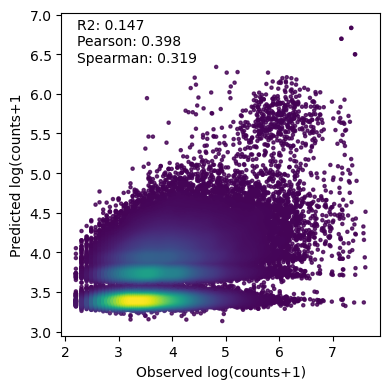

In [440]:
scatter(
    x=y_log_counts.detach().numpy().squeeze(),
    y=y_counts.detach().numpy().squeeze(),
    c="#4682B4",
    alpha=0.8,
    xlabel="Observed log(counts+1)",
    ylabel="Predicted log(counts+1",
    density=True,
    add_reference_line=False,
    rasterized=True,
    s=5,
)

## Validation sequence visualization

In [429]:
# Get an expected count distribution
y_probs = y_probs.reshape(y_probs.shape[0], -1)
expected_counts = y_probs * y_pred_counts

In [430]:
# Reshape the counts to match
y_valid_reshape = y_valid.reshape(y_valid.shape[0], -1)

In [431]:
# Best predictions
ordered_inds = np.argsort(pearsons)[::-1]
pearsons[ordered_inds[:5]], ordered_inds[:5]

(array([0.9683482 , 0.968112  , 0.96575034, 0.9656878 , 0.9654718 ],
       dtype=float32),
 array([26228, 26229, 79097, 79096, 26230]))

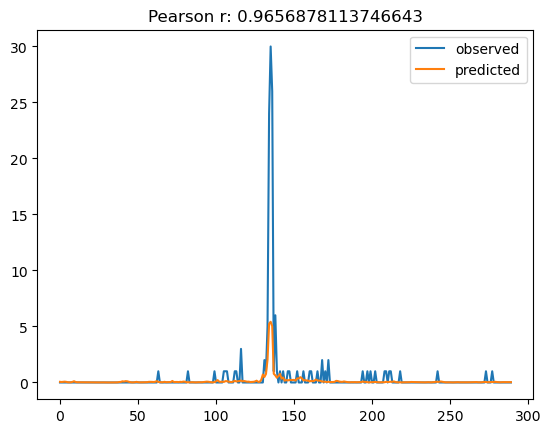

In [432]:
seq_num = 79096
plt.title(f"Pearson r: {pearsons[seq_num]}")
plt.plot(y_valid_reshape[seq_num].detach().numpy(), label="observed")
plt.plot(expected_counts[seq_num].detach().numpy(), label="predicted")
plt.legend()

## Test loss and metrics

In [442]:
test_sdata = sd.open_zarr(os.path.join(data_dir, 'test.zarr')).load()

In [443]:
X_test = seq_trans(test_sdata["seq"].values)
X_ctl_test = ctl_trans(test_sdata["control"].values)
y_test = cov_trans(test_sdata["signal"].values)
X_test.shape, X_ctl_test.shape, y_test.shape

(torch.Size([58622, 4, 300]),
 torch.Size([58622, 1, 300]),
 torch.Size([58622, 1, 290]))

In [444]:
# Get actual counts and log counts 
y_actual_counts = y_test.sum(dim=-1)
y_log_counts = torch.log(y_actual_counts+1)
y_log_counts.shape

torch.Size([58622, 1])

In [445]:
# Get predicted profile and log counts
y_profile, y_counts = model.predict(X=X_test, X_ctl=X_ctl_test)
y_profile.shape, y_counts.shape

(torch.Size([58622, 1, 290]), torch.Size([58622, 1]))

In [446]:
# Get the predicted profiles into probability distribtion
z = y_profile.shape
y_profile = y_profile.reshape(y_profile.shape[0], -1)
y_profile = torch.nn.functional.log_softmax(y_profile, dim=-1)
y_profile = y_profile.reshape(*z)
y_probs = torch.exp(y_profile)
y_probs.shape

torch.Size([58622, 1, 290])

In [447]:
# Get the predicted counts into non-log space
y_pred_counts = torch.exp(y_counts)
y_pred_counts.shape

torch.Size([58622, 1])

In [448]:
# Use Jacob's methods for performance
measures = calculate_performance_measures(y_profile, 
    y_test, y_counts, kernel_sigma=7, 
    kernel_width=81, measures=['profile_mnll', 
    'profile_pearson', 'count_pearson', 'count_mse'])
valid_loss = measures['profile_mnll'].mean() + measures['count_mse']
profile_corr = measures['profile_pearson']
count_corr = measures['count_pearson']
valid_loss.mean(), profile_corr.mean(), count_corr.mean()

(tensor(106.7138), tensor(0.4540), tensor(0.3676))

In [449]:
# My own
pearson_corr(y_probs, y_test).mean(), pearson_corr(y_counts.T, y_log_counts.T).mean()

(tensor(0.4540), tensor(0.3676))

In [450]:
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr


def scatter(
    x,
    y,
    ax=None,
    density=False,
    c="b",
    alpha=1,
    s=10,
    xlabel="Observed",
    ylabel="Predicted",
    figsize=(4, 4),
    save=None,
    add_reference_line=True,
    rasterized=False,
):
    # Set up the axes
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Drop NA values if any
    x_nas = np.isnan(x)
    y_nas = np.isnan(y)
    x = x[~x_nas & ~y_nas]
    y = y[~x_nas & ~y_nas]

    if density:
        # Get point densities
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        c=z

    # Plot the points
    ax.scatter(x, y, c=c, s=s, rasterized=rasterized, alpha=alpha)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Add scores
    r2 = r2_score(x, y)
    pearson_r = pearsonr(x, y)
    spearman_r = spearmanr(x, y)
    ax.annotate(f"R2: {r2:.3f}", (0.05, 0.95), xycoords="axes fraction")
    ax.annotate(f"Pearson: {pearson_r[0]:.3f}", (0.05, 0.90), xycoords="axes fraction")
    ax.annotate(f"Spearman: {spearman_r[0]:.3f}", (0.05, 0.85), xycoords="axes fraction")
    
    # Add y=x line for reference but make the mins and maxes extend past the data
    if add_reference_line:
        min_val = min(min(x), min(y))
        max_val = max(max(x), max(y))
        ax.plot([min_val, max_val], [min_val, max_val], c="k", ls="--", lw=1)
    
    # Plt
    plt.tight_layout()

    # Save
    if save:
        plt.savefig(save, dpi=300)
        plt.close()
    else:
        plt.show()

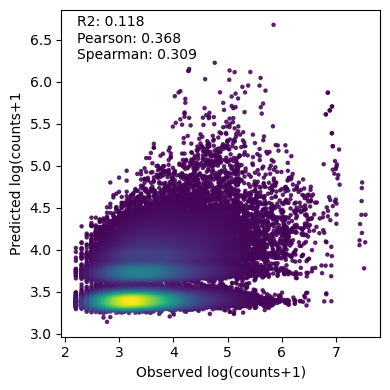

In [451]:
scatter(
    x=y_log_counts.detach().numpy().squeeze(),
    y=y_counts.detach().numpy().squeeze(),
    c="#4682B4",
    alpha=0.8,
    xlabel="Observed log(counts+1)",
    ylabel="Predicted log(counts+1",
    density=True,
    add_reference_line=False,
    rasterized=True,
    s=5,
)

## Test sequence visualization

In [482]:
# Get an expected count distribution
y_probs = y_probs.reshape(y_probs.shape[0], -1)
expected_counts = y_probs * y_actual_counts

In [483]:
# Reshape the counts to match
y_test_reshape = y_test.reshape(y_test.shape[0], -1)

In [484]:
pearsons = pearson_corr(expected_counts, y_test_reshape).detach().numpy().squeeze()
pearsons.mean()

0.4539867

In [485]:
# Best predictions
ordered_inds = np.argsort(pearsons)[::-1]
pearsons[ordered_inds[:5]], ordered_inds[:5]

(array([0.97222143, 0.97086763, 0.9703707 , 0.96996856, 0.96983963],
       dtype=float32),
 array([52496, 52495, 52494, 54456, 52493]))

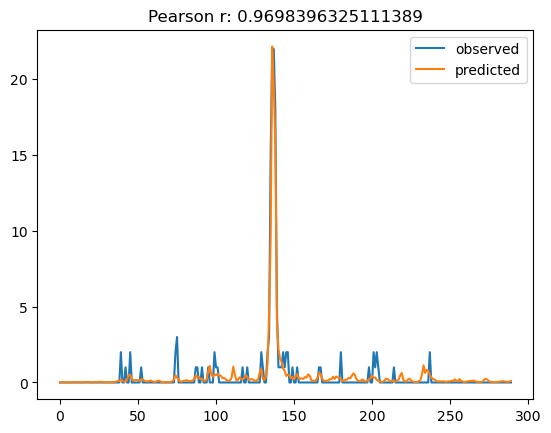

In [491]:
seq_num = 52493
plt.title(f"Pearson r: {pearsons[seq_num]}")
plt.plot(y_test_reshape[seq_num].detach().numpy(), label="observed")
plt.plot(expected_counts[seq_num].detach().numpy(), label="predicted")
plt.legend()

## Test set attributions

In [492]:
from bpnetlite.attributions import calculate_attributions, plot_attributions

In [493]:
X = X_test
X_ctl = (torch.zeros(X.shape[0], model.n_control_tracks, X.shape[-1]),)

In [489]:
attrs = calculate_attributions(
    model=model,
    X=X,
    args=X_ctl,
    n_shuffles=10,
    batch_size=128,
    warning_threshold=1,
    verbose=True
)

100%|██████████| 458/458 [01:13<00:00,  6.24it/s]


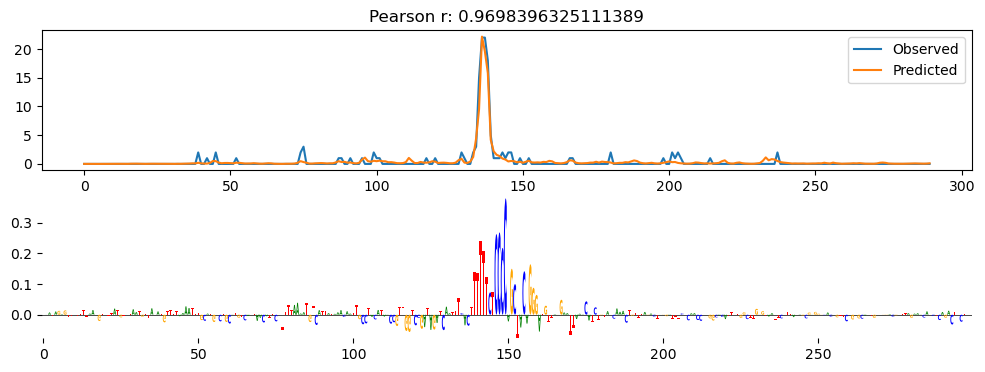

In [494]:
seq_num = 52493
fig, ax = plt.subplots(2, 1, figsize=(12, 4))
ax[0].plot(y_test_reshape[seq_num].detach().numpy(), label="Observed")
ax[0].plot(expected_counts[seq_num].detach().numpy(), label="Predicted")
ax[0].set_title(f"Pearson r: {pearsons[seq_num]}")
ax[0].legend()
plot_attributions(
    X_attr=attrs[seq_num],
    ax=ax[1]
)